In [2]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

The Deepface framework we used in our study also uses the OpenCv library during the face detection phase. In the process of recognition and vector expression of the face, it uses deep learning-based facial recognition models (Serengil &Özpinar, 2020). Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value(Serengil, 2020b).

In this notebook which is prepared by Serengil(2020b), we will find the best split point for a threshold with teh Mix Data Set.

For the original notebook, see:
https://github.com/serengil/deepface/blob/master/tests/Fine-Tuning-Threshold.ipynb

# Mix Data set

In [3]:
idendities = {
    "Laura_Harrier": ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg"],
    "Zendaya": ["img5.jpg", "img6.jpg", "img7.jpg", "img8.jpg"],
    "Tom_Holland": ["img9.jpg", "img10.jpg", "img11.jpg", "img12.jpg"],
    "Andrew_Garfield": ["img13.jpg", "img14.jpg", "img15.jpg", "img16.jpg"],
    "Jodie_Comer":["img17.jpg", "img18.jpg", "img19.jpg", "img20.jpg"],
    "Emma_Stone": ["img21.jpg", "img22.jpg", "img23.jpg", "img24.jpg"],
    "Will_Smith": ["img25.jpg", "img26.jpg", "img27.jpg", "img28.jpg"],
    "Lance Reddick": ["img29.jpg", "img30.jpg", "img31.jpg", "img32.jpg"],
    "Lee_Jung_jae": ["img33.jpg", "img34.jpg", "img35.jpg", "img36.jpg"],
    "Choi_Min_sik": ["img37.jpg", "img38.jpg", "img39.jpg", "img40.jpg"],
    "HoYeon Jung": ["img41.jpg", "img42.jpg", "img43.jpg", "img44.jpg"],
    "Sandra_Oh": ["img45.jpg", "img46.jpg", "img47.jpg", "img48.jpg"]
}

# Positive samples
Find different photos of same people

In [4]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [5]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

# Negative samples
Compare photos of different people

In [6]:
samples_list = list(idendities.values())

In [7]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
        

In [8]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

# Merge Positives and Negative Samples

In [9]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [10]:
df.shape

(1128, 3)

In [11]:
df.decision.value_counts()

No     1056
Yes      72
Name: decision, dtype: int64

In [12]:
df.file_x = "dataset/"+df.file_x
df.file_y = "dataset/"+df.file_y

# DeepFace

In [13]:
from deepface import DeepFace

In [14]:
instances = df[["file_x", "file_y"]].values.tolist()

In [15]:
model_name = "VGG-Face"
distance_metric = "cosine"

In [16]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)

Verification: 100%|████████████████████████████████████████████████████████████████| 1128/1128 [38:56<00:00,  2.07s/it]


In [21]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [22]:
df["distance"] = distances

# Analyzing Distances

In [23]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)

In [24]:
print("Mean of true positives: ", tp_mean)
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Mean of true positives:  0.1863
Std of true positives:  0.061
Mean of false positives:  0.6576
Std of false positives:  0.1284


# Distribution

<AxesSubplot:ylabel='Density'>

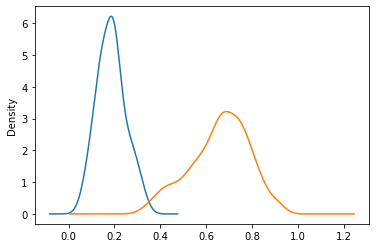

In [25]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

# Sigma

In [324]:
sigma = 3
#2 sigma corresponds 95.45% confidence, and 3 sigma corresponds 99.73% confidence

#threshold = round(tp_mean + sigma * tp_std, 4)
threshold = 0.383 #comes from c4.5 algorithm
print("threshold: ", threshold)

threshold:  0.383


In [303]:
df[df.decision == 'Yes'].distance.max()

0.3359

In [304]:
df[df.decision == 'No'].distance.min()

0.3145

# Evaluation

In [325]:
df["prediction"] = "No"

In [326]:
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [327]:
df.head(5)

,file_x,file_y,decision,distance,prediction
0,dataset/img1.jpg,dataset/img2.jpg,Yes,0.1874,Yes
1,dataset/img1.jpg,dataset/img3.jpg,Yes,0.1283,Yes
2,dataset/img1.jpg,dataset/img4.jpg,Yes,0.1408,Yes
3,dataset/img2.jpg,dataset/img3.jpg,Yes,0.1472,Yes
4,dataset/img2.jpg,dataset/img4.jpg,Yes,0.0822,Yes


In [328]:
cm = confusion_matrix(df.decision.values, df.prediction.values)

In [329]:
cm

array([[1028,   28],
       [   0,   72]], dtype=int64)

In [330]:
tn, fp, fn, tp = cm.ravel()

In [331]:
tn, fp, fn, tp

(1028, 28, 0, 72)

In [332]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [333]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  72.0 %
Recall:  100.0 %
F1 score  83.72093023255813 %
Accuracy:  97.51773049645391 %


In [252]:
df.to_csv("threshold_pivot.csv", index = False)

## Test results

### Threshold = 0.199 

Precision:  100.0 %
Recall:  61.11%
F1 score   75.86 %
Accuracy:  97.5% (Human**)

### Threshold =  0.2473 (1 sigma)

Precision:  100.0 %
Recall:  83.33 %
F1 score  90.90 %
Accuracy:  98.93 % 

### Threshold =  0.3083 (2 sigma)
     
Precision:  100.0 %
Recall:  97.22 %
F1 score  98.59 %
Accuracy:  99.82 % 

### Threshold =  0.3693 (3 sigma)

Precision:  79.12 %
Recall:  100.0 %
F1 score  88.34 %
Accuracy:  98.31 %

### Threshold =  0.383 

Precision:  72.0 %
Recall:  100.0 %
F1 score  83.72 %
Accuracy:  97.5 %
